# S&P 500 Direction Prediction using Machine Learning

## Overview
This project uses historical S&P 500 data and technical indicators to predict market direction using XGBoost.

## Data
- Source: Yahoo Finance
- Ticker: ^GSPC (S&P 500)

In [1]:
import yfinance as yf
import numpy as np
import ta
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score
from xgboost import XGBClassifier

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500 = sp500.loc["1990-01-01":].copy()

In [5]:
sp500.drop(columns=["Dividends", "Stock Splits"], errors="ignore", inplace=True)


<Axes: xlabel='Date'>

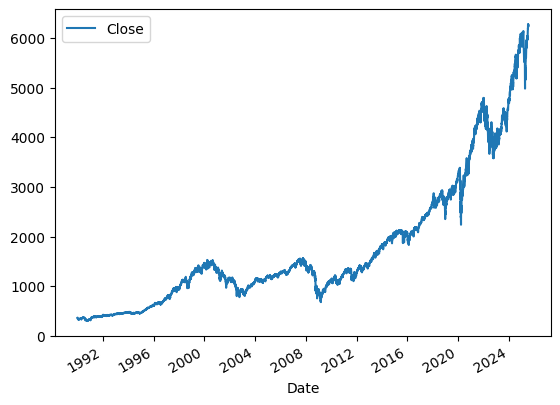

In [6]:
sp500.plot.line(y="Close",use_index=True)

## Features
- Technical indicators: RSI, MACD, SMA, Volatility
- Lag features
- Rolling averages
- Time-based features

In [7]:
sp500["RSI"] = ta.momentum.RSIIndicator(close=sp500["Close"]).rsi()

In [8]:
sp500["MACD"] = ta.trend.MACD(close=sp500["Close"]).macd()

In [9]:
sp500["SMA_50"] = sp500["Close"].rolling(50).mean()

In [10]:
sp500["SMA_200"] = sp500["Close"].rolling(200).mean()

In [11]:
sp500["Volatility_20"] = sp500["Close"].rolling(20).std()

In [12]:
for lag in range(1, 6):
    sp500[f"Close_Lag_{lag}"] = sp500["Close"].shift(lag)
    sp500[f"Volume_Lag_{lag}"] = sp500["Volume"].shift(lag)

In [13]:
sp500["5_Day_Future"] = sp500["Close"].shift(-5)

In [14]:
sp500["Target"] = (sp500["5_Day_Future"] > sp500["Close"]).astype(int)

In [15]:
sp500 = sp500.dropna().copy()

In [16]:
predictors = ["Close", "Open", "High", "Low", "Volume",
    "RSI", "MACD", "SMA_50", "SMA_200", "Volatility_20",
    "Close_Lag_1", "Close_Lag_2", "Close_Lag_3", "Close_Lag_4", "Close_Lag_5",
    "Volume_Lag_1", "Volume_Lag_2", "Volume_Lag_3", "Volume_Lag_4", "Volume_Lag_5"]

## Model
- XGBoostClassifier

In [17]:
model = XGBClassifier(
    n_estimators=275,
    max_depth=4,
    learning_rate=0.035,
    eval_metric="logloss",
    random_state=1)

In [18]:
def predict(train, test, predictors, model, threshold = 0.6):
    model.fit(train[predictors], train["Target"])
    probs = model.predict_proba(test[predictors])[:, 1]
    preds = (probs >= threshold).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
    

In [19]:
def backtest(data, model, predictors, start=2500, step=250,threshold=0.6):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model, threshold)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [20]:
predictions = backtest(sp500, model, predictors)

In [21]:
predictions["Predictions"].value_counts() 

Predictions
0    3866
1    2377
Name: count, dtype: int64

In [22]:
print("\nBase Rate:\n", predictions["Target"].value_counts() / predictions.shape[0])


Base Rate:
 Target
1    0.572481
0    0.427519
Name: count, dtype: float64


## Precision
- 57.0%

In [23]:
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"Precision: {precision:.4f}")

Precision: 0.5700


## Tommorow's Prediction

In [24]:
latest_features = sp500[predictors].iloc[-1:].copy()

tomorrow_prediction = model.predict(latest_features)[0]
tomorrow_proba = model.predict_proba(latest_features)[0]

print("➡️ Tomorrow's Prediction:", "UP" if tomorrow_prediction == 1 else "DOWN")
print(f"📈 Probability of UP: {tomorrow_proba[1]:.3f}")
print(f"📉 Probability of DOWN: {tomorrow_proba[0]:.3f}")


➡️ Tomorrow's Prediction: DOWN
📈 Probability of UP: 0.150
📉 Probability of DOWN: 0.850


## Key Takeaways
- Outperformed random guessing
- Framework for trading simulation